# 04e Summary differential expression treatments + export to xls

Run with this command in docker container

docker run 
--rm 
-d 
--name scanpy2 
-p 8880:8888 
-e JUPYTER_ENABLE_LAB=YES 
-v /Users/efast/Documents/:/home/jovyan/work 
scanpy:1.4.6

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from gprofiler import GProfiler
import seaborn as sns; sns.set() 
from helper_functions import *
from openpyxl.workbook import Workbook

from upsetplot import UpSet
import re

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

## Extract differentially expressed genes for each treatment

In [2]:
# Extract differentially expressed gene numbers for each treatment

files = ['1.5', '1.2', 'nocutoff']
treatments = ['dmPGE2', 'GCSF', 'indo', 'pIC']


for treatment in treatments:
    results_df=[]
    results_df = pd.DataFrame(columns=['fold change', 'total_HSC_only', 'up_HSC_only', 'down_HSC_only',
                                   'total_MPP_only', 'up_MPP_only', 'down_MPP_only', 
                                   'total_overlap', 'up_overlap', 'down_overlap', 'directionality_difference'])
    
    for file in files: 
        path_name_out = './write/overlaps_' + treatment + '_' + '.csv'
        path_name_in = './write/' + treatment + '_combo_HSCs_MPPs_' + file + '.csv'
        diff_genes = pd.read_csv(path_name_in)

        total_HSC_only = len(diff_genes[diff_genes['specific'] =='HSC_only'])
        total_MPP_only = len(diff_genes[diff_genes['specific'] =='MPP_only'])
        total_overlap = len(diff_genes[diff_genes['specific'] =='overlap'])

        up_HSC_only = len(diff_genes[(diff_genes['specific'] =='HSC_only') & (diff_genes['HSC_any'] > 0)])
        down_HSC_only = len(diff_genes[(diff_genes['specific'] =='HSC_only') & (diff_genes['HSC_any'] < 0)])
        up_MPP_only = len(diff_genes[(diff_genes['specific'] =='MPP_only') & (diff_genes['MPP_any'] > 0)])
        down_MPP_only = len(diff_genes[(diff_genes['specific'] =='MPP_only') & (diff_genes['MPP_any'] < 0)])
        up_overlap = len(diff_genes[(diff_genes['specific'] =='overlap') & (diff_genes['HSC_any'] > 0) & (diff_genes['MPP_any'] > 0)])
        down_overlap = len(diff_genes[(diff_genes['specific'] =='overlap') & (diff_genes['HSC_any'] < 0) & (diff_genes['MPP_any'] < 0)])

        directionality =  len(diff_genes[diff_genes['overlap'] < 0])

        results_df = results_df.append(pd.DataFrame([[file, total_HSC_only, up_HSC_only, down_HSC_only,
                                       total_MPP_only, up_MPP_only, down_MPP_only, total_overlap, up_overlap, 
                                        down_overlap, directionality]], 
                                        columns=['fold change', 'total_HSC_only', 'up_HSC_only', 'down_HSC_only',
                                       'total_MPP_only', 'up_MPP_only', 'down_MPP_only', 
                                       'total_overlap', 'up_overlap', 'down_overlap', 'directionality_difference']))

    results_df = results_df.set_index('fold change')
    results_df = results_df.T
    results_df.to_csv(path_name_out, index=True, header=True)

## Plotting of results

In [3]:
sns.set_style("ticks")

In [4]:
# define function

def plot_proportions(treatment):
    path_name_in = './write/overlaps_' + treatment + '_' + '.csv'
    df_all = pd.read_csv(path_name_in)
    df_clean = df_all[(df_all['Unnamed: 0'] != 'total_MPP_only') &
                       (df_all['Unnamed: 0'] != 'total_overlap') &
                       (df_all['Unnamed: 0'] != 'total_HSC_only')]
    df_clean = df_clean.set_index('Unnamed: 0')
    percent_df = df_clean.iloc[:,0:6].div(df_clean.sum(axis=0), axis=1)
    percent_df = percent_df.reindex(['up_HSC_only',
                                     'down_HSC_only',
                                     'directionality_difference',
                                     'up_overlap',
                                     'down_overlap',
                                     'up_MPP_only',
                                     'down_MPP_only',
                                     ])
    ax = percent_df.T.plot.bar(stacked=True, color = def_color)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.ylabel("proportion of cells")
    out_path = './figures/overlap_bargraph_' + treatment + '.pdf'
    return plt.savefig(out_path, bbox_inches = "tight"), plt.show(), print(df_clean.sum(axis=0))

In [5]:
# define some colors to identify clusters

def_color = ['#7D3C98',
             '#BB8FCE',
             '#17202A',
             '#566573',
             '#D5D8DC',
             '#229954',
             '#7DCEA0']

#https://htmlcolorcodes.com/color-chart/

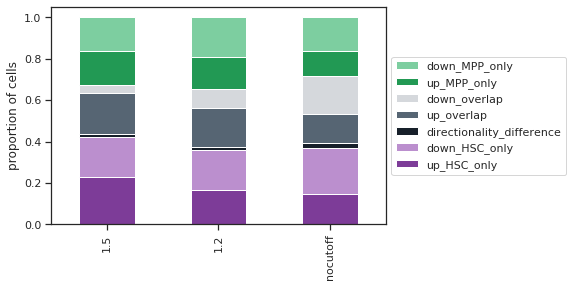

1.5          191
1.2          987
nocutoff    4819
dtype: int64


(None, None, None)

In [6]:
plot_proportions('dmPGE2')

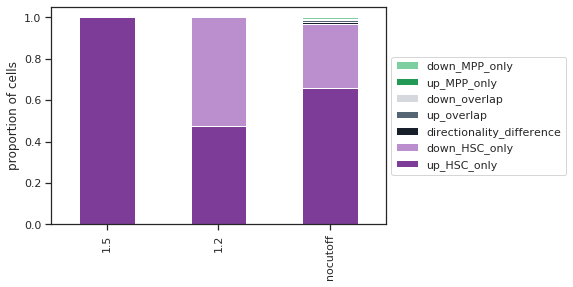

1.5           1
1.2          21
nocutoff    844
dtype: int64


(None, None, None)

In [7]:
plot_proportions('indo')

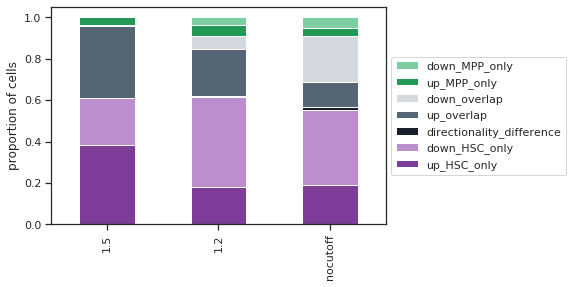

1.5          249
1.2          981
nocutoff    6251
dtype: int64


(None, None, None)

In [8]:
plot_proportions('pIC')

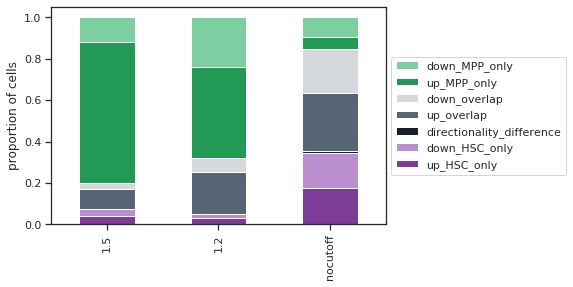

1.5           94
1.2         1004
nocutoff    5947
dtype: int64


(None, None, None)

In [9]:
plot_proportions('GCSF')

## Export average gene expression per clusters

In [11]:
# read in and prepare adata object MPPs

adata = sc.read('./sc_objects/MPP_preprocessed.h5ad')
adata.var_names_make_unique()
adata.rename_categories('leiden', ['Primed', 'Metabolism', 'Stem cell', 'Cell-cycle', 'Acute-Activation', 
                                   'Interferon', 'Interferon cell-cycle','Myeloid'])
adata.obs['cluster_sample'] = adata.obs['sample'].str.cat(others = adata.obs['leiden'], sep='_')
adata.obs['cluster_sample']=adata.obs['cluster_sample'].astype('category', copy=True) # make a column with category as dtype

fold_changes = ['1.5', '1.2', 'nocutoff']
treatments = ['dmPGE2', 'GCSF', 'indo', 'pIC']

for treatment in treatments:
    for fold_change in fold_changes:
        path_in = './write/' + treatment + '_combo_HSCs_MPPs_' + fold_change + '.csv'
        
        diff_genes = pd.read_csv(path_in)
        diff_genes = diff_genes[diff_genes['specific'] != 'HSC_only'] # exclude HSC genes for MPPs

        # make dictonary from marker genes
        dict_gene = diff_genes.groupby('specific')['primerid'].apply(list).to_dict()

        # calculate average expression per cluster
        avg = average_expression(adata, dict_gene, gene_symbol_key=None, partition_key='cluster_sample')
        sheet_name = treatment + '_' + fold_change
        with pd.ExcelWriter('./write/MPP_avg_geneexpression.xlsx', mode='a') as writer: 
            avg.to_excel(writer, sheet_name=sheet_name)

In [12]:
# read in and prepare adata object LTs

adata = sc.read('./sc_objects/LT_preprocessed.h5ad')
adata.var_names_make_unique()
adata.rename_categories('leiden', ['Metabolism', 'Quiescent', 'Activated', 'Interferon', 'Acute-Activation', 'Cell-cycle'])
adata.obs['cluster_sample'] = adata.obs['sample'].str.cat(others = adata.obs['leiden'], sep='_')
adata.obs['cluster_sample']=adata.obs['cluster_sample'].astype('category', copy=True) # make a column with category as dtype

fold_changes = ['1.5', '1.2', 'nocutoff']
treatments = ['dmPGE2', 'GCSF', 'indo', 'pIC']

for treatment in treatments:
    for fold_change in fold_changes:
        path_in = './write/' + treatment + '_combo_HSCs_MPPs_' + fold_change + '.csv'
        
        diff_genes = pd.read_csv(path_in)
        diff_genes = diff_genes[diff_genes['specific'] != 'MPP_only'] # exclude MPP genes for LTs

        # make dictonary from marker genes
        dict_gene = diff_genes.groupby('specific')['primerid'].apply(list).to_dict()

        # calculate average expression per cluster
        avg = average_expression(adata, dict_gene, gene_symbol_key=None, partition_key='cluster_sample')
        sheet_name = treatment + '_' + fold_change
        with pd.ExcelWriter('./write/LT_avg_geneexpression.xlsx', mode='a') as writer: 
            avg.to_excel(writer, sheet_name=sheet_name)

In [13]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.3.final.0
python-bits      : 64
OS               : Linux
OS-release       : 4.19.76-linuxkit
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : en_US.UTF-8
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 0.25.3
numpy            : 1.17.3
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 19.3.1
setuptools       : 41.6.0.post20191101
Cython           : 0.29.14
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.10.3
IPython          : 7.9.0
pandas_datareader: None
bs4              : 4.8.1
bottleneck       : None
fastparquet      : None
gcsfs            : None
lxml.etree       : None
matplotlib       :

In [12]:
!pip list

Package                Version            
---------------------- -------------------
alembic                1.3.0              
anndata                0.7.1              
async-generator        1.10               
attrs                  19.3.0             
backcall               0.1.0              
beautifulsoup4         4.8.1              
bleach                 3.1.0              
blinker                1.4                
bokeh                  1.3.4              
cellbrowser            0.7.7              
certifi                2020.4.5.1         
certipy                0.1.3              
cffi                   1.13.2             
chardet                3.0.4              
Click                  7.0                
cloudpickle            1.2.2              
conda                  4.7.12             
conda-package-handling 1.6.0              
cryptography           2.8                
cycler                 0.10.0             
Cython                 0.29.14            
cytoolz    